In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
transform = transforms.ToTensor()

In [3]:
train = datasets.MNIST(root='../Course/Data', train=True, download=True, transform=transform)

In [4]:
test = datasets.MNIST(root='../Course/Data', train=False, download=True, transform=transform)

In [5]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Course/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Course/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = train[0] 

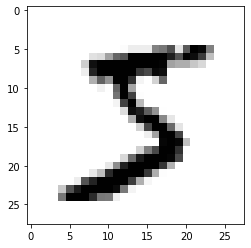

In [8]:
plt.imshow(image.reshape(28, 28), cmap='gist_yarg')

In [9]:
label

5

In [10]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=200, shuffle=False)

In [11]:
class ANN(nn.Module):
    def __init__(self, in_size=784, out_size=10, layers=[128, 64]):
        super().__init__()
        
        self.fc1 = nn.Linear(in_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.out = nn.Linear(layers[1], out_size)
        
    def forward(self, X):
        x = F.leaky_relu(self.fc1(X), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

In [12]:
model = ANN().cuda()

In [13]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
losses = []
val_losses = []
correct = []
val_correct = []

In [14]:
start_time = time.time()

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        y_hat = model(X_train.view(100, -1))
        loss = criterion(y_hat, y_train)
        
        pred = torch.max(y_hat.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr
        
        # back propagation
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # display training metrics
        if b%200 == 0:
            accuracy = train_corr.item()*100/(100*b)
            print("Epoch {} Batch Number {}".format(e+1, b))
            print("Accuracy: {:.4f}  Loss: {:.4f}".format(accuracy, loss))
    
    losses.append(loss)
    correct.append(train_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test.view(200, -1))
            pred = torch.max(y_val, 1)[1]
            val_corr += (pred == y_test).sum()
    
    val_loss = criterion(y_val, y_test)
    val_losses.append(val_loss)
    val_correct.append(val_corr)

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch Number 200
Accuracy: 83.6050  Loss: 0.3162
Epoch 1 Batch Number 400
Accuracy: 87.4775  Loss: 0.3028
Epoch 1 Batch Number 600
Accuracy: 89.1850  Loss: 0.1772
Epoch 2 Batch Number 200
Accuracy: 93.9750  Loss: 0.2862
Epoch 2 Batch Number 400
Accuracy: 94.2025  Loss: 0.2135
Epoch 2 Batch Number 600
Accuracy: 94.4150  Loss: 0.2608
Epoch 3 Batch Number 200
Accuracy: 95.7550  Loss: 0.0735
Epoch 3 Batch Number 400
Accuracy: 95.9625  Loss: 0.1657
Epoch 3 Batch Number 600
Accuracy: 96.0700  Loss: 0.1498
Epoch 4 Batch Number 200
Accuracy: 96.7900  Loss: 0.1122
Epoch 4 Batch Number 400
Accuracy: 96.8450  Loss: 0.0974
Epoch 4 Batch Number 600
Accuracy: 96.8883  Loss: 0.0321
Epoch 5 Batch Number 200
Accuracy: 97.4500  Loss: 0.0992
Epoch 5 Batch Number 400
Accuracy: 97.5550  Loss: 0.1229
Epoch 5 Batch Number 600
Accuracy: 97.5083  Loss: 0.0186
Epoch 6 Batch Number 200
Accuracy: 97.9250  Loss: 0.0445
Epoch 6 Batch Number 400
Accuracy: 97.9275  Loss: 0.1588
Epoch 6 Batch Number 600
Accura

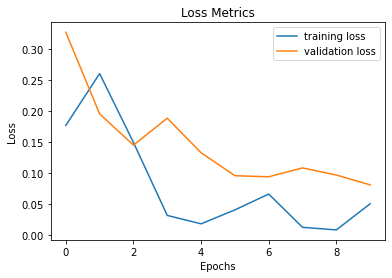

In [15]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [16]:
acc = [train_corr/600 for train_corr in correct]
val_acc = [test_corr/100 for test_corr in val_correct]

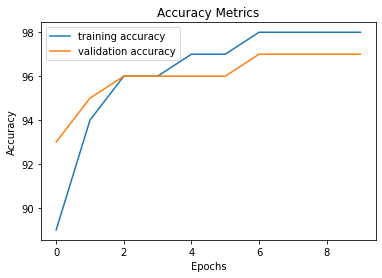

In [17]:
plt.plot(range(epochs), acc, label='training accuracy')
plt.plot(range(epochs), val_acc, label='validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [61]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(5*5*32, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        X = F.leaky_relu(self.conv1(X), negative_slope=0.2)
        X = F.max_pool2d(X, 2, 2)
        X = F.leaky_relu(self.conv2(X), negative_slope=0.2)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 32*5*5)
        X = F.leaky_relu(self.fc1(X), negative_slope=0.2)
        X = F.leaky_relu(self.fc2(X), negative_slope=0.2)
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [62]:
model = CNN().cuda()

In [63]:
train_loader = DataLoader(train, batch_size=100, shuffle=True)
test_loader = DataLoader(test, batch_size=200, shuffle=False)

In [64]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
losses = []
val_losses = []
correct = []
val_correct = []

In [65]:
start_time = time.time()

for e in range(epochs):
    train_corr = 0
    val_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        
        pred = torch.max(y_hat.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr
        
        # back propagation
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # display training metrics
        if b%600 == 0:
            accuracy = train_corr.item()*100/(100*b)
            print("Epoch {}".format(e+1, b))
            print("Accuracy: {:.4f}  Loss: {:.4f}".format(accuracy, loss))
    
    losses.append(loss)
    correct.append(train_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            pred = torch.max(y_val, 1)[1]
            val_corr += (pred == y_test).sum()
    
    val_loss = criterion(y_val, y_test)
    val_losses.append(val_loss)
    val_correct.append(val_corr)

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1
Accuracy: 90.9067  Loss: 0.0624
Epoch 2
Accuracy: 97.7633  Loss: 0.0538
Epoch 3
Accuracy: 98.4633  Loss: 0.1032
Epoch 4
Accuracy: 98.7900  Loss: 0.0302
Epoch 5
Accuracy: 99.0467  Loss: 0.0078
Epoch 6
Accuracy: 99.1717  Loss: 0.0071
Epoch 7
Accuracy: 99.3350  Loss: 0.0277
Epoch 8
Accuracy: 99.4300  Loss: 0.0090
Epoch 9
Accuracy: 99.5500  Loss: 0.0046
Epoch 10
Accuracy: 99.5600  Loss: 0.0016

Training Duration 1.8660 minutes
GPU memory used : 21655040 kb
GPU memory cached : 52428800 kb


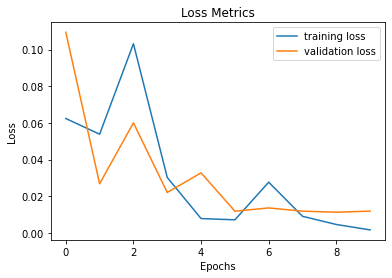

In [66]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [67]:
acc = [train_corr/600 for train_corr in correct]
val_acc = [test_corr/100 for test_corr in val_correct]

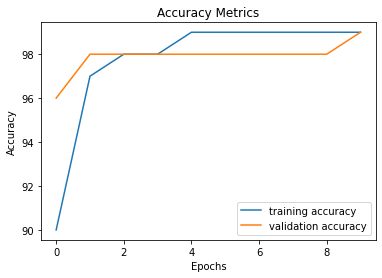

In [68]:
plt.plot(range(epochs), acc, label='training accuracy')
plt.plot(range(epochs), val_acc, label='validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()